# CNN avec transfert learning

## Base

### EfficientNet


Nombre total d'images dans le dossier 'DB/images/': 1053

Recherche des meilleurs hyperparamètres pour KMeans...
Recherche 1/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 7, 'n_init': 10, 'tol': 0.1}
ARI pour les paramètres {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 7, 'n_init': 10, 'tol': 0.1}: 0.1535
Recherche 2/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 12, 'n_init': 10, 'tol': 0.1}
ARI pour les paramètres {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 12, 'n_init': 10, 'tol': 0.1}: 0.2528
Recherche 3/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 13, 'n_init': 10, 'tol': 0.1}
ARI pour les paramètres {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 13, 'n_init': 10, 'tol': 0.1}: 0.2961
Recherche 4/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means+

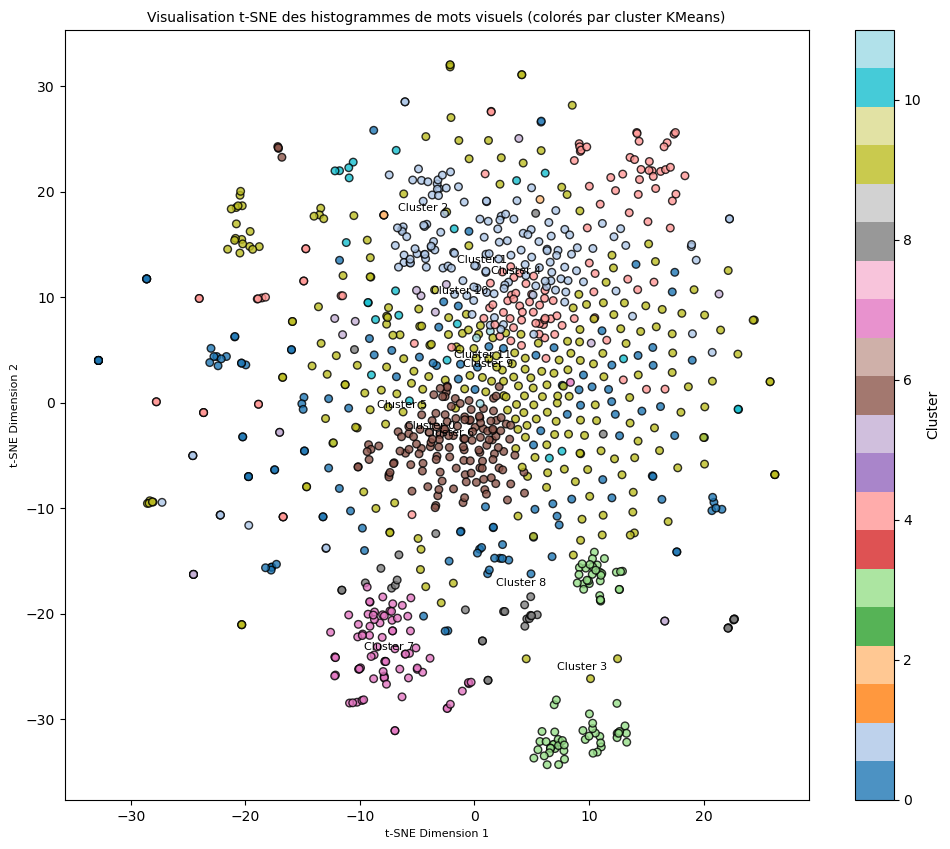


Indice de Rand Ajusté (ARI) final : 0.4465

FIN


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import re
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from keras.applications.efficientnet import EfficientNetB0, preprocess_input
from keras.preprocessing import image as keras_image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import contextlib
import sys
from sklearn.preprocessing import LabelEncoder

# Charger le dataset Flipkart
df_product = pd.read_csv('DB/flipkart.csv')
df_product.columns = df_product.columns.str.strip()

# Extraire la première catégorie de 'product_category_tree' si elle est présente
if 'product_category_tree' in df_product.columns:
    df_product['main_category'] = df_product['product_category_tree'].apply(
        lambda x: re.findall(r'^\["(.*?)\s*>>', x)[0] if pd.notnull(x) and re.findall(r'^\["(.*?)\s*>>', x) else None
    )

# Répertoire des images
folder = 'DB/images/'
image_files = os.listdir(folder)
print(f"\nNombre total d'images dans le dossier '{folder}': {len(image_files)}")

images = []
image_labels = []  # Liste pour stocker les étiquettes de chaque image
for filename in image_files:
    path = os.path.join(folder, filename)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is not None:
        # Redimensionnement pour que l'image respecte la taille maximale de 224x224
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB
        images.append(img)
        
        # Récupérer l'étiquette de chaque image (associer avec l'image par son nom)
        category = df_product[df_product['image'] == filename]['main_category'].values
        if category:
            image_labels.append(category[0])  # Assurez-vous que la catégorie existe

# Fonction pour extraire les caractéristiques des images avec EfficientNetB0
model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=model.input, outputs=model.output)

# Fonction pour supprimer les messages de progression de TensorFlow
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Extraction des caractéristiques des images sans afficher les messages de progression
features = []
with suppress_stdout():  # Masquer les messages de TensorFlow
    for idx, img in enumerate(images):
        img_np = np.array(img)  # Conversion en numpy array
        img_preprocessed = preprocess_input(img_np)  # Prétraiter l'image
        img_expanded = np.expand_dims(img_preprocessed, axis=0)  # Ajouter la dimension batch
        feature = model.predict(img_expanded)
        feature_flat = feature.flatten()  # Aplatir le vecteur des caractéristiques
        features.append(feature_flat)
        print(f"Extraction des caractéristiques pour l'image {idx + 1}/{len(images)} terminée.")

# Recherche des meilleurs hyperparamètres pour KMeans
print("\nRecherche des meilleurs hyperparamètres pour KMeans...")

param_grid = {
    'n_clusters': [7,12, 13, 11],
    'init': ['k-means++', 'random'],
    'max_iter': [1000],
    'n_init': [10],
    'tol': [1e-1],
    'algorithm': ['lloyd', 'elkan']
}

best_score = -1
best_model = None
best_params = {}

# Conversion des étiquettes des images en catégories numériques
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(image_labels)  # Convertir les étiquettes en indices numériques

# Recherche des meilleurs paramètres
for i, params in enumerate(ParameterGrid(param_grid)):
    print(f"Recherche {i+1}/{len(ParameterGrid(param_grid))} - Paramètres: {params}")
    
    kmeans = KMeans(
        n_clusters=params['n_clusters'],
        init=params['init'],
        max_iter=params['max_iter'],
        n_init=params['n_init'],
        tol=params['tol'],
        algorithm=params['algorithm'],
        random_state=0
    )
    kmeans.fit(np.array(features, dtype=np.float64))  # Convertir en float64 pour éviter l'erreur
    predicted_labels = kmeans.predict(np.array(features, dtype=np.float64))
    
    # Calcul de l'ARI (Adjusted Rand Index) si les vraies étiquettes sont disponibles
    ari_score = adjusted_rand_score(true_labels, predicted_labels[:len(true_labels)])
    print(f"ARI pour les paramètres {params}: {ari_score:.4f}")
    if ari_score > best_score:
        best_score = ari_score
        best_model = kmeans
        best_params = params

print(f"\nMeilleurs paramètres : {best_params} avec un score ARI de {best_score:.4f}")

# Réduction de dimension avec t-SNE pour la visualisation
df_histograms = np.array(features)  # Utilisation des caractéristiques extraites
scaler = StandardScaler()
df_histograms = scaler.fit_transform(df_histograms)

tsne = TSNE(n_components=2, random_state=0)
histograms_2d = tsne.fit_transform(df_histograms)

# Visualisation des données réduites en 2D avec les clusters
plt.figure(figsize=(12, 10))

# Utilisation d'une palette de couleurs plus visible
scatter = plt.scatter(histograms_2d[:, 0], histograms_2d[:, 1], 
                      c=best_model.labels_[:len(histograms_2d)], 
                      cmap='tab20', alpha=0.8, edgecolors='k', s=30)

# Ajout de la légende
plt.colorbar(scatter, label='Cluster')
plt.title("Visualisation t-SNE des histogrammes de mots visuels (colorés par cluster KMeans)", fontsize=10)
plt.xlabel("t-SNE Dimension 1", fontsize=8)
plt.ylabel("t-SNE Dimension 2", fontsize=8)

# Ajouter des labels pour les clusters
clusters = np.unique(best_model.labels_)
for cluster in clusters:
    plt.text(np.mean(histograms_2d[best_model.labels_ == cluster, 0]), 
             np.mean(histograms_2d[best_model.labels_ == cluster, 1]), 
             f'Cluster {cluster}', fontsize=8, color='black', ha='center')

plt.show()

# Calcul de l'ARI final (si les vraies étiquettes sont disponibles)
ari_score = adjusted_rand_score(true_labels, best_model.labels_[:len(true_labels)])
print(f"\nIndice de Rand Ajusté (ARI) final : {ari_score:.4f}")

print("\nFIN")


### Efficientnetv2


Nombre total d'images dans le dossier 'DB/images/': 1053

Recherche des meilleurs hyperparamètres pour KMeans...
Recherche 1/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 7, 'n_init': 10, 'tol': 0.1}
ARI pour les paramètres {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 7, 'n_init': 10, 'tol': 0.1}: 0.3769
Recherche 2/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 12, 'n_init': 10, 'tol': 0.1}
ARI pour les paramètres {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 12, 'n_init': 10, 'tol': 0.1}: 0.3851
Recherche 3/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 13, 'n_init': 10, 'tol': 0.1}
ARI pour les paramètres {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 13, 'n_init': 10, 'tol': 0.1}: 0.2856
Recherche 4/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means+

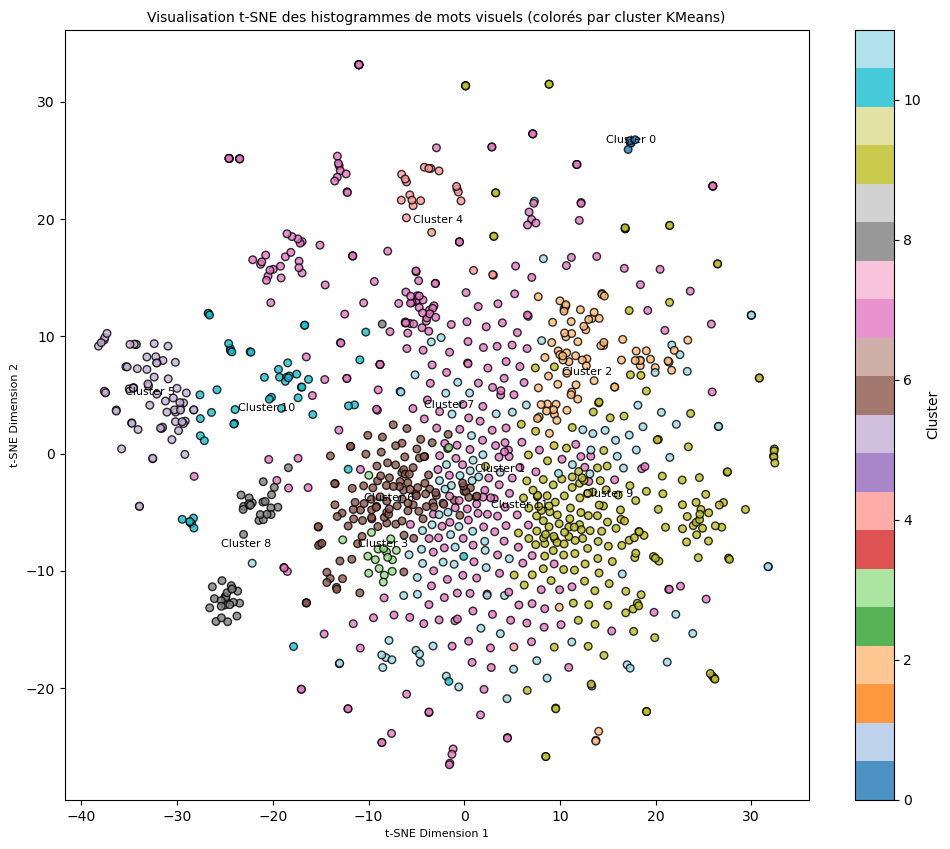


Indice de Rand Ajusté (ARI) final : 0.3855

FIN


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import re
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import ParameterGrid
from keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from keras.preprocessing import image as keras_image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import contextlib
import sys

# Charger le dataset Flipkart
df_product = pd.read_csv('DB/flipkart.csv')
df_product.columns = df_product.columns.str.strip()

# Extraire la première catégorie de 'product_category_tree' si elle est présente
if 'product_category_tree' in df_product.columns:
    df_product['main_category'] = df_product['product_category_tree'].apply(
        lambda x: re.findall(r'^\["(.*?)\s*>>', x)[0] if pd.notnull(x) and re.findall(r'^\["(.*?)\s*>>', x) else None
    )

# Répertoire des images
folder = 'DB/images/'
image_files = os.listdir(folder)
print(f"\nNombre total d'images dans le dossier '{folder}': {len(image_files)}")

images = []
image_labels = []  # Liste pour stocker les étiquettes de chaque image
for filename in image_files:
    path = os.path.join(folder, filename)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is not None:
        # Redimensionnement pour que l'image respecte la taille maximale de 224x224
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB
        images.append(img)
        
        # Récupérer l'étiquette de chaque image (associer avec l'image par son nom)
        category = df_product[df_product['image'] == filename]['main_category'].values
        if category:
            image_labels.append(category[0])  # Assurez-vous que la catégorie existe

# Fonction pour extraire les caractéristiques des images avec EfficientNetV2
model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=model.input, outputs=model.output)

# Fonction pour supprimer les messages de progression de TensorFlow
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Extraction des caractéristiques des images sans afficher les messages de progression
features = []
with suppress_stdout():  # Masquer les messages de TensorFlow
    for idx, img in enumerate(images):
        img_np = np.array(img)  # Conversion en numpy array
        img_preprocessed = preprocess_input(img_np)  # Prétraiter l'image
        img_expanded = np.expand_dims(img_preprocessed, axis=0)  # Ajouter la dimension batch
        feature = model.predict(img_expanded)
        feature_flat = feature.flatten()  # Aplatir le vecteur des caractéristiques
        features.append(feature_flat)
        print(f"Extraction des caractéristiques pour l'image {idx + 1}/{len(images)} terminée.")

# Recherche des meilleurs hyperparamètres pour KMeans
print("\nRecherche des meilleurs hyperparamètres pour KMeans...")

param_grid = {
    'n_clusters': [7,12, 13, 11],
    'init': ['k-means++', 'random'],
    'max_iter': [1000],
    'n_init': [10],
    'tol': [1e-1],
    'algorithm': ['lloyd', 'elkan']
}

best_score = -1
best_model = None
best_params = {}

# Conversion des étiquettes des images en catégories numériques
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(image_labels)  # Convertir les étiquettes en indices numériques

# Recherche des meilleurs paramètres
for i, params in enumerate(ParameterGrid(param_grid)):
    print(f"Recherche {i+1}/{len(ParameterGrid(param_grid))} - Paramètres: {params}")
    
    kmeans = KMeans(
        n_clusters=params['n_clusters'],
        init=params['init'],
        max_iter=params['max_iter'],
        n_init=params['n_init'],
        tol=params['tol'],
        algorithm=params['algorithm'],
        random_state=0
    )
    kmeans.fit(np.array(features, dtype=np.float64))  # Convertir en float64 pour éviter l'erreur
    predicted_labels = kmeans.predict(np.array(features, dtype=np.float64))
    
    # Calcul de l'ARI (Adjusted Rand Index) si les vraies étiquettes sont disponibles
    ari_score = adjusted_rand_score(true_labels, predicted_labels[:len(true_labels)])
    print(f"ARI pour les paramètres {params}: {ari_score:.4f}")
    if ari_score > best_score:
        best_score = ari_score
        best_model = kmeans
        best_params = params

print(f"\nMeilleurs paramètres : {best_params} avec un score ARI de {best_score:.4f}")

# Réduction de dimension avec t-SNE pour la visualisation
df_histograms = np.array(features)  # Utilisation des caractéristiques extraites
scaler = StandardScaler()
df_histograms = scaler.fit_transform(df_histograms)

tsne = TSNE(n_components=2, random_state=0)
histograms_2d = tsne.fit_transform(df_histograms)

# Visualisation des données réduites en 2D avec les clusters
plt.figure(figsize=(12, 10))

# Utilisation d'une palette de couleurs plus visible
scatter = plt.scatter(histograms_2d[:, 0], histograms_2d[:, 1], 
                      c=best_model.labels_[:len(histograms_2d)], 
                      cmap='tab20', alpha=0.8, edgecolors='k', s=30)

# Ajout de la légende
plt.colorbar(scatter, label='Cluster')
plt.title("Visualisation t-SNE des histogrammes de mots visuels (colorés par cluster KMeans)", fontsize=10)
plt.xlabel("t-SNE Dimension 1", fontsize=8)
plt.ylabel("t-SNE Dimension 2", fontsize=8)

# Ajouter des labels pour les clusters
clusters = np.unique(best_model.labels_)
for cluster in clusters:
    plt.text(np.mean(histograms_2d[best_model.labels_ == cluster, 0]), 
             np.mean(histograms_2d[best_model.labels_ == cluster, 1]), 
             f'Cluster {cluster}', fontsize=8, color='black', ha='center')

plt.show()

# Calcul de l'ARI final (si les vraies étiquettes sont disponibles)
ari_score = adjusted_rand_score(true_labels, best_model.labels_[:len(true_labels)])
print(f"\nIndice de Rand Ajusté (ARI) final : {ari_score:.4f}")

print("\nFIN")


### ConvNeXt


Nombre total d'images dans le dossier 'DB/images/': 1053

Recherche des meilleurs hyperparamètres pour KMeans...
Recherche 1/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 7, 'n_init': 10, 'tol': 0.1}
ARI pour les paramètres {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 7, 'n_init': 10, 'tol': 0.1}: 0.3619
Recherche 2/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 12, 'n_init': 10, 'tol': 0.1}
ARI pour les paramètres {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 12, 'n_init': 10, 'tol': 0.1}: 0.3179
Recherche 3/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 13, 'n_init': 10, 'tol': 0.1}
ARI pour les paramètres {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 13, 'n_init': 10, 'tol': 0.1}: 0.4276
Recherche 4/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means+

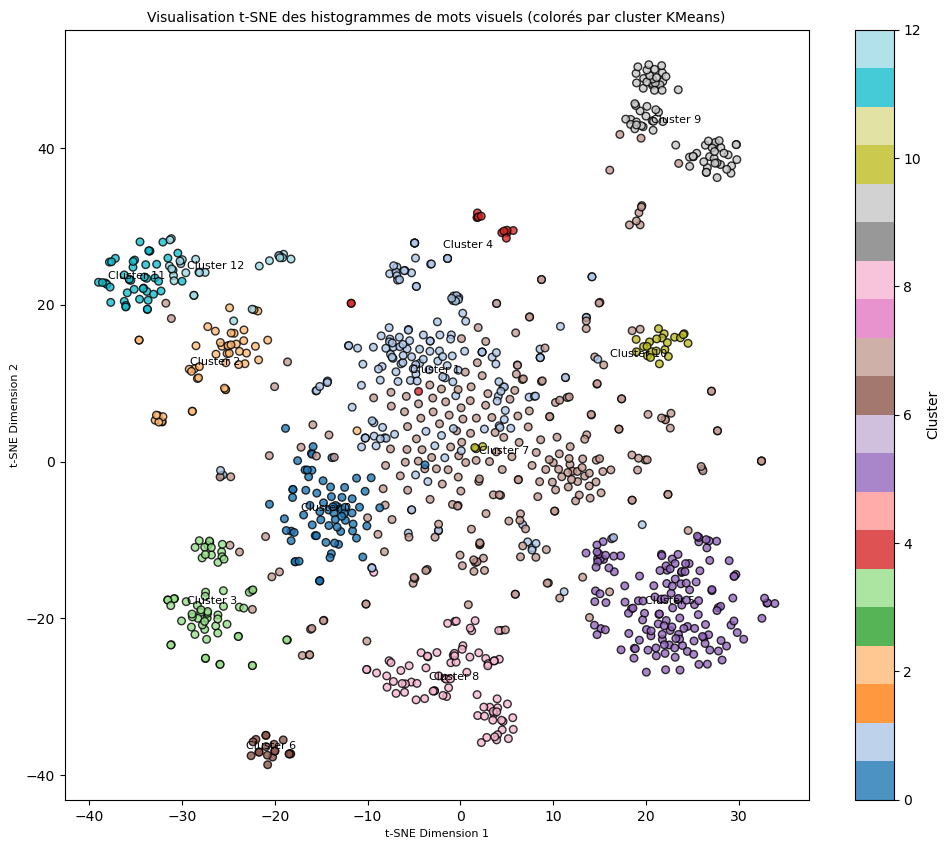


Indice de Rand Ajusté (ARI) final : 0.4482

FIN


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import re
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import ParameterGrid
from keras.applications.convnext import ConvNeXtBase, preprocess_input
from keras.preprocessing import image as keras_image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import contextlib
import sys

# Charger le dataset Flipkart
df_product = pd.read_csv('DB/flipkart.csv')
df_product.columns = df_product.columns.str.strip()

# Extraire la première catégorie de 'product_category_tree' si elle est présente
if 'product_category_tree' in df_product.columns:
    df_product['main_category'] = df_product['product_category_tree'].apply(
        lambda x: re.findall(r'^\["(.*?)\s*>>', x)[0] if pd.notnull(x) and re.findall(r'^\["(.*?)\s*>>', x) else None
    )

# Répertoire des images
folder = 'DB/images/'
image_files = os.listdir(folder)
print(f"\nNombre total d'images dans le dossier '{folder}': {len(image_files)}")

images = []
image_labels = []  # Liste pour stocker les étiquettes de chaque image
for filename in image_files:
    path = os.path.join(folder, filename)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is not None:
        # Redimensionnement pour que l'image respecte la taille maximale de 224x224
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB
        images.append(img)
        
        # Récupérer l'étiquette de chaque image (associer avec l'image par son nom)
        category = df_product[df_product['image'] == filename]['main_category'].values
        if category:
            image_labels.append(category[0])  # Assurez-vous que la catégorie existe

# Fonction pour extraire les caractéristiques des images avec ConvNeXt
model = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=model.input, outputs=model.output)

# Fonction pour supprimer les messages de progression de TensorFlow
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Extraction des caractéristiques des images sans afficher les messages de progression
features = []
with suppress_stdout():  # Masquer les messages de TensorFlow
    for idx, img in enumerate(images):
        img_np = np.array(img)  # Conversion en numpy array
        img_preprocessed = preprocess_input(img_np)  # Prétraiter l'image
        img_expanded = np.expand_dims(img_preprocessed, axis=0)  # Ajouter la dimension batch
        feature = model.predict(img_expanded)
        feature_flat = feature.flatten()  # Aplatir le vecteur des caractéristiques
        features.append(feature_flat)
        print(f"Extraction des caractéristiques pour l'image {idx + 1}/{len(images)} terminée.")

# Recherche des meilleurs hyperparamètres pour KMeans
print("\nRecherche des meilleurs hyperparamètres pour KMeans...")

param_grid = {
    'n_clusters': [7,12, 13, 11],
    'init': ['k-means++', 'random'],
    'max_iter': [1000],
    'n_init': [10],
    'tol': [1e-1],
    'algorithm': ['lloyd', 'elkan']
}

best_score = -1
best_model = None
best_params = {}

# Conversion des étiquettes des images en catégories numériques
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(image_labels)  # Convertir les étiquettes en indices numériques

# Recherche des meilleurs paramètres
for i, params in enumerate(ParameterGrid(param_grid)):
    print(f"Recherche {i+1}/{len(ParameterGrid(param_grid))} - Paramètres: {params}")
    
    kmeans = KMeans(
        n_clusters=params['n_clusters'],
        init=params['init'],
        max_iter=params['max_iter'],
        n_init=params['n_init'],
        tol=params['tol'],
        algorithm=params['algorithm'],
        random_state=0
    )
    kmeans.fit(np.array(features, dtype=np.float64))  # Convertir en float64 pour éviter l'erreur
    predicted_labels = kmeans.predict(np.array(features, dtype=np.float64))
    
    # Calcul de l'ARI (Adjusted Rand Index) si les vraies étiquettes sont disponibles
    ari_score = adjusted_rand_score(true_labels, predicted_labels[:len(true_labels)])
    print(f"ARI pour les paramètres {params}: {ari_score:.4f}")
    if ari_score > best_score:
        best_score = ari_score
        best_model = kmeans
        best_params = params

print(f"\nMeilleurs paramètres : {best_params} avec un score ARI de {best_score:.4f}")

# Réduction de dimension avec t-SNE pour la visualisation
df_histograms = np.array(features)  # Utilisation des caractéristiques extraites
scaler = StandardScaler()
df_histograms = scaler.fit_transform(df_histograms)

tsne = TSNE(n_components=2, random_state=0)
histograms_2d = tsne.fit_transform(df_histograms)

# Visualisation des données réduites en 2D avec les clusters
plt.figure(figsize=(12, 10))

# Utilisation d'une palette de couleurs plus visible
scatter = plt.scatter(histograms_2d[:, 0], histograms_2d[:, 1], 
                      c=best_model.labels_[:len(histograms_2d)], 
                      cmap='tab20', alpha=0.8, edgecolors='k', s=30)

# Ajout de la légende
plt.colorbar(scatter, label='Cluster')
plt.title("Visualisation t-SNE des histogrammes de mots visuels (colorés par cluster KMeans)", fontsize=10)
plt.xlabel("t-SNE Dimension 1", fontsize=8)
plt.ylabel("t-SNE Dimension 2", fontsize=8)

# Ajouter des labels pour les clusters
clusters = np.unique(best_model.labels_)
for cluster in clusters:
    plt.text(np.mean(histograms_2d[best_model.labels_ == cluster, 0]), 
             np.mean(histograms_2d[best_model.labels_ == cluster, 1]), 
             f'Cluster {cluster}', fontsize=8, color='black', ha='center')

plt.show()

# Calcul de l'ARI final (si les vraies étiquettes sont disponibles)
ari_score = adjusted_rand_score(true_labels, best_model.labels_[:len(true_labels)])
print(f"\nIndice de Rand Ajusté (ARI) final : {ari_score:.4f}")

print("\nFIN")


### Récapitulatif

In [18]:
from tabulate import tabulate

# Données à afficher dans le tableau
data = [
    ["EfficientNetB0", "{'algorithm': 'lloyd', 'init': 'random', 'max_iter': 1000, 'n_clusters': 12, 'n_init': 10, 'tol': 0.1}", 0.4465],
    ["EfficientNetV2", "{'algorithm': 'lloyd', 'init': 'random', 'max_iter': 1000, 'n_clusters': 12, 'n_init': 10, 'tol': 0.1}", 0.3855],
    ["ConvNeXt", "{'algorithm': 'lloyd', 'init': 'random', 'max_iter': 1000, 'n_clusters': 13, 'n_init': 10, 'tol': 0.1}", 0.4482],
]

# Trouver les deux meilleurs scores ARI
sorted_data = sorted(data, key=lambda x: x[2], reverse=True)
top_scores = {sorted_data[0][2], sorted_data[1][2]}

# Mettre en valeur les deux meilleures lignes
highlighted_data = []
for row in data:
    if row[2] in top_scores:
        highlighted_data.append([f"\033[92m{cell}\033[0m" for cell in row])  # Met toute la ligne en vert
    else:
        highlighted_data.append(row)

# Entêtes des colonnes
headers = ["Modèle", "Meilleurs Paramètres", "ARI"]

# Affichage du tableau formaté
print(tabulate(highlighted_data, headers=headers, tablefmt="pretty"))


+----------------+--------------------------------------------------------------------------------------------------------+--------+
|     Modèle     |                                          Meilleurs Paramètres                                          |  ARI   |
+----------------+--------------------------------------------------------------------------------------------------------+--------+
| EfficientNetB0 | {'algorithm': 'lloyd', 'init': 'random', 'max_iter': 1000, 'n_clusters': 12, 'n_init': 10, 'tol': 0.1} | 0.4465 |
| EfficientNetV2 | {'algorithm': 'lloyd', 'init': 'random', 'max_iter': 1000, 'n_clusters': 12, 'n_init': 10, 'tol': 0.1} | 0.3855 |
|    ConvNeXt    | {'algorithm': 'lloyd', 'init': 'random', 'max_iter': 1000, 'n_clusters': 13, 'n_init': 10, 'tol': 0.1} | 0.4482 |
+----------------+--------------------------------------------------------------------------------------------------------+--------+


## Finetuning

#### EfficientNetB0


Nombre total d'images dans le dossier 'DB/images/': 1053

Recherche des meilleurs hyperparamètres pour KMeans...
Recherche 1/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 7, 'n_init': 10, 'tol': 0.1}
ARI pour les paramètres {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 7, 'n_init': 10, 'tol': 0.1}: 0.1535
Recherche 2/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 12, 'n_init': 10, 'tol': 0.1}
ARI pour les paramètres {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 12, 'n_init': 10, 'tol': 0.1}: 0.2528
Recherche 3/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 13, 'n_init': 10, 'tol': 0.1}
ARI pour les paramètres {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 13, 'n_init': 10, 'tol': 0.1}: 0.2961
Recherche 4/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means+

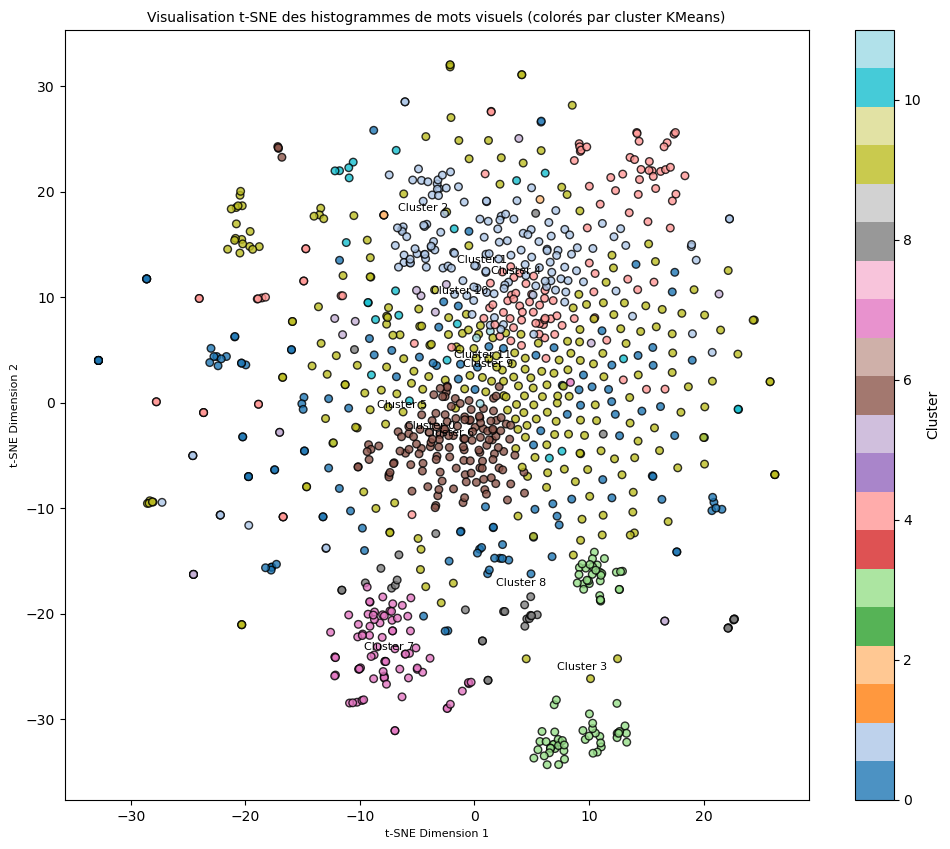


Indice de Rand Ajusté (ARI) final : 0.4465


Model: "functional_88"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_78      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_35        │ (None, 224, 224,  │          0 │ input_layer_78[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_18    │ (None, 224, 224,  │          7 │ rescaling_35[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_36        │ (None, 224, 224,  │          0 │ normalization_18… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_36[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 5,368,490 (20.48 MB)

 Trainable params: 1,318,919 (5.03 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/9
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.4177 - loss: 1.6882 - val_accuracy: 0.7810 - val_loss: 0.9357
Epoch 2/9
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.8237 - loss: 0.8099 - val_accuracy: 0.8238 - val_loss: 0.6538
Epoch 3/9
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.8881 - loss: 0.5055 - val_accuracy: 0.8429 - val_loss: 0.5833
Epoch 4/9
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.8987 - loss: 0.3934 - val_accuracy: 0.8476 - val_loss: 0.5463
Epoch 5/9
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.9235 - loss: 0.3257 - val_accuracy: 0.8429 - val_loss: 0.5274
Epoch 6/9
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.9304 - loss: 0.2645 - val_accuracy: 0.8333 - val_loss: 0.5156
Epoch 7/9
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.9541 - loss: 0.2178 - val_accuracy: 0.8429 - val_loss: 0.5060
Epoch 8/9
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.9528 - loss: 0.1966 - val_accuracy: 0.8381 - v

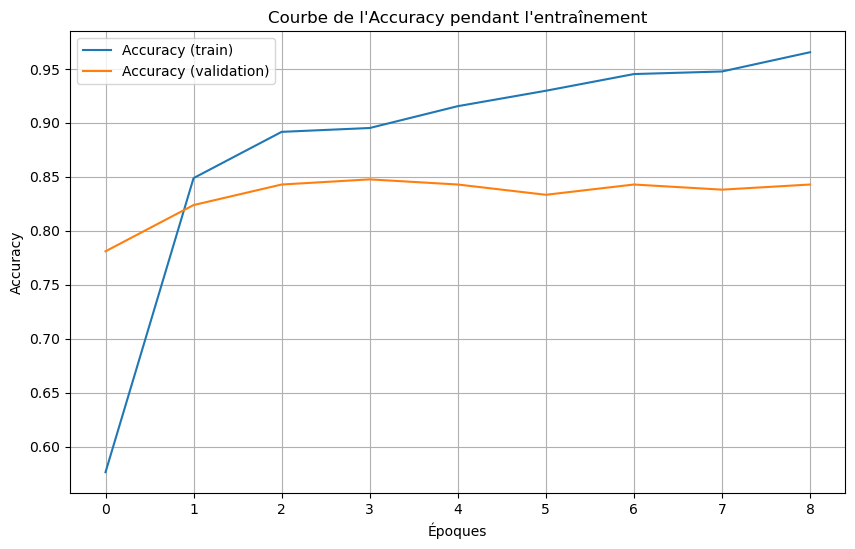

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import re
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from keras.applications.efficientnet import EfficientNetB0, preprocess_input
from keras.preprocessing import image as keras_image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import contextlib
import sys
from sklearn.preprocessing import LabelEncoder
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam

# Charger le dataset Flipkart
df_product = pd.read_csv('DB/flipkart.csv')
df_product.columns = df_product.columns.str.strip()

# Extraire la première catégorie de 'product_category_tree' si elle est présente
if 'product_category_tree' in df_product.columns:
    df_product['main_category'] = df_product['product_category_tree'].apply(
        lambda x: re.findall(r'^\["(.*?)\s*>>', x)[0] if pd.notnull(x) and re.findall(r'^\["(.*?)\s*>>', x) else None
    )

# Répertoire des images
folder = 'DB/images/'
image_files = os.listdir(folder)
print(f"\nNombre total d'images dans le dossier '{folder}': {len(image_files)}")

images = []
image_labels = []  # Liste pour stocker les étiquettes de chaque image
for filename in image_files:
    path = os.path.join(folder, filename)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is not None:
        # Redimensionnement pour que l'image respecte la taille maximale de 224x224
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB
        images.append(img)
        
        # Récupérer l'étiquette de chaque image (associer avec l'image par son nom)
        category = df_product[df_product['image'] == filename]['main_category'].values
        if category:
            image_labels.append(category[0])  # Assurez-vous que la catégorie existe

# Fonction pour extraire les caractéristiques des images avec EfficientNetB0
model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=model.input, outputs=model.output)

# Fonction pour supprimer les messages de progression de TensorFlow
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Extraction des caractéristiques des images sans afficher les messages de progression
features = []
with suppress_stdout():  # Masquer les messages de TensorFlow
    for idx, img in enumerate(images):
        img_np = np.array(img)  # Conversion en numpy array
        img_preprocessed = preprocess_input(img_np)  # Prétraiter l'image
        img_expanded = np.expand_dims(img_preprocessed, axis=0)  # Ajouter la dimension batch
        feature = model.predict(img_expanded)
        feature_flat = feature.flatten()  # Aplatir le vecteur des caractéristiques
        features.append(feature_flat)
        print(f"Extraction des caractéristiques pour l'image {idx + 1}/{len(images)} terminée.")

# Recherche des meilleurs hyperparamètres pour KMeans
print("\nRecherche des meilleurs hyperparamètres pour KMeans...")

param_grid = {
    'n_clusters': [7,12, 13, 11],
    'init': ['k-means++', 'random'],
    'max_iter': [1000],
    'n_init': [10],
    'tol': [1e-1],
    'algorithm': ['lloyd', 'elkan']
}

best_score = -1
best_model = None
best_params = {}

# Conversion des étiquettes des images en catégories numériques
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(image_labels)  # Convertir les étiquettes en indices numériques

# Recherche des meilleurs paramètres
for i, params in enumerate(ParameterGrid(param_grid)):
    print(f"Recherche {i+1}/{len(ParameterGrid(param_grid))} - Paramètres: {params}")
    
    kmeans = KMeans(
        n_clusters=params['n_clusters'],
        init=params['init'],
        max_iter=params['max_iter'],
        n_init=params['n_init'],
        tol=params['tol'],
        algorithm=params['algorithm'],
        random_state=0
    )
    kmeans.fit(np.array(features, dtype=np.float64))  # Convertir en float64 pour éviter l'erreur
    predicted_labels = kmeans.predict(np.array(features, dtype=np.float64))
    
    # Calcul de l'ARI (Adjusted Rand Index) si les vraies étiquettes sont disponibles
    ari_score = adjusted_rand_score(true_labels, predicted_labels[:len(true_labels)])
    print(f"ARI pour les paramètres {params}: {ari_score:.4f}")
    if ari_score > best_score:
        best_score = ari_score
        best_model = kmeans
        best_params = params

print(f"\nMeilleurs paramètres : {best_params} avec un score ARI de {best_score:.4f}")

# Réduction de dimension avec t-SNE pour la visualisation
df_histograms = np.array(features)  # Utilisation des caractéristiques extraites
scaler = StandardScaler()
df_histograms = scaler.fit_transform(df_histograms)

tsne = TSNE(n_components=2, random_state=0)
histograms_2d = tsne.fit_transform(df_histograms)

# Visualisation des données réduites en 2D avec les clusters
plt.figure(figsize=(12, 10))

# Utilisation d'une palette de couleurs plus visible
scatter = plt.scatter(histograms_2d[:, 0], histograms_2d[:, 1], 
                      c=best_model.labels_[:len(histograms_2d)], 
                      cmap='tab20', alpha=0.8, edgecolors='k', s=30)

# Ajout de la légende
plt.colorbar(scatter, label='Cluster')
plt.title("Visualisation t-SNE des histogrammes de mots visuels (colorés par cluster KMeans)", fontsize=10)
plt.xlabel("t-SNE Dimension 1", fontsize=8)
plt.ylabel("t-SNE Dimension 2", fontsize=8)

# Ajouter des labels pour les clusters
clusters = np.unique(best_model.labels_)
for cluster in clusters:
    plt.text(np.mean(histograms_2d[best_model.labels_ == cluster, 0]), 
             np.mean(histograms_2d[best_model.labels_ == cluster, 1]), 
             f'Cluster {cluster}', fontsize=8, color='black', ha='center')

plt.show()

# Calcul de l'ARI final (si les vraies étiquettes sont disponibles)
ari_score = adjusted_rand_score(true_labels, best_model.labels_[:len(true_labels)])
print(f"\nIndice de Rand Ajusté (ARI) final : {ari_score:.4f}")

# ---- Finetuning du modèle EfficientNetB0 ----

# Charger EfficientNetB0 sans la couche de classification (include_top=False)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler toutes les couches du modèle de base (les premières couches)
for layer in base_model.layers:
    layer.trainable = False

# Ajouter une nouvelle tête pour la classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling global pour réduire la taille
x = Dropout(0.2)(x)  # Dropout pour éviter le sur-apprentissage
x = Dense(1024, activation='relu')(x)  # Couche dense avec 1024 neurones
predictions = Dense(len(np.unique(true_labels)), activation='softmax')(x)  # Classification multi-classes

# Créer un modèle final
model_finetuned = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle avec le paramètre `learning_rate` au lieu de `lr`
model_finetuned.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model_finetuned.summary()

# Entraîner le modèle sur vos données
history = model_finetuned.fit(
    np.array(images),  # Données d'images
    np.array(true_labels),  # Étiquettes correspondantes
    epochs=9,  # Nombre d'époques (vous pouvez ajuster)
    batch_size=32,  # Taille du batch
    validation_split=0.2,  # Fraction des données pour la validation
    shuffle=True  # Mélanger les données à chaque époque
)

# Prédire les étiquettes avec le modèle fine-tuné
predictions = model_finetuned.predict(np.array(images))
predicted_labels_finetuned = np.argmax(predictions, axis=1)  # Récupérer les prédictions avec la classe la plus probable

# Calcul de l'ARI après fine-tuning
ari_score_finetuned = adjusted_rand_score(true_labels, predicted_labels_finetuned)
print(f"\nIndice de Rand Ajusté (ARI) après le fine-tuning : {ari_score_finetuned:.4f}")

# Plot du graphique d'accuracy pendant l'entraînement
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Accuracy (train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)')
plt.title('Courbe de l\'Accuracy pendant l\'entraînement')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


#### ConvNeXt


Nombre total d'images dans le dossier 'DB/images/': 1053

Recherche des meilleurs hyperparamètres pour KMeans...
Recherche 1/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 7, 'n_init': 10, 'tol': 0.1}
ARI pour les paramètres {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 7, 'n_init': 10, 'tol': 0.1}: 0.3619
Recherche 2/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 12, 'n_init': 10, 'tol': 0.1}
ARI pour les paramètres {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 12, 'n_init': 10, 'tol': 0.1}: 0.3179
Recherche 3/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 13, 'n_init': 10, 'tol': 0.1}
ARI pour les paramètres {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 1000, 'n_clusters': 13, 'n_init': 10, 'tol': 0.1}: 0.4276
Recherche 4/16 - Paramètres: {'algorithm': 'lloyd', 'init': 'k-means+

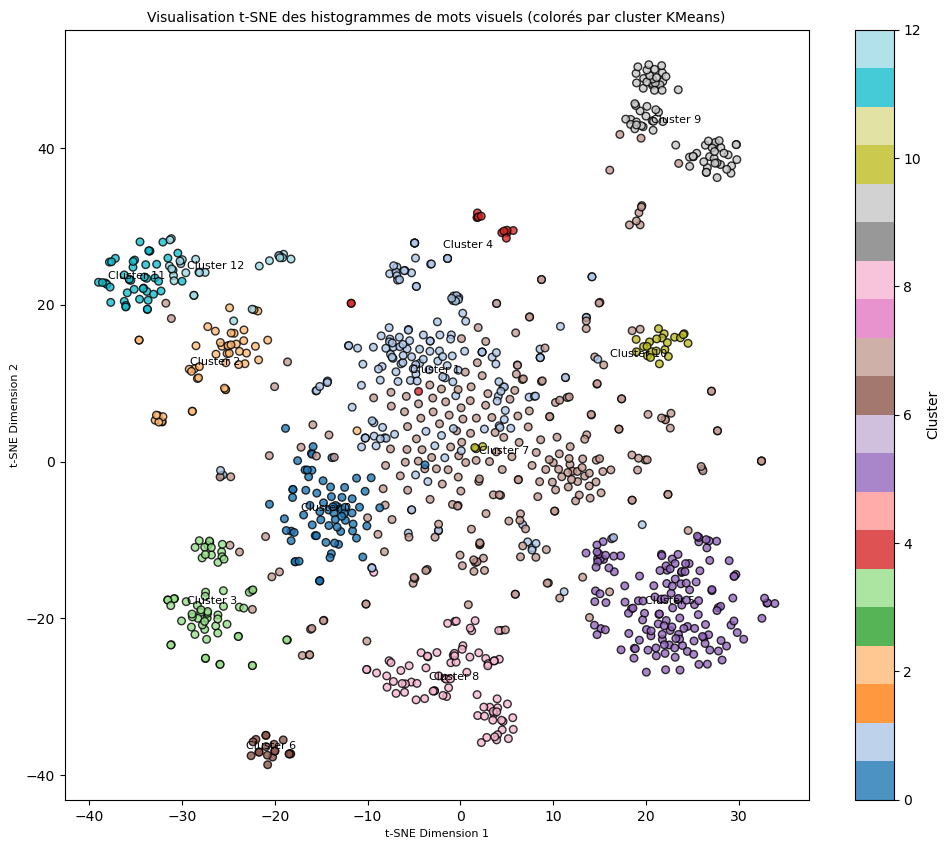


Indice de Rand Ajusté (ARI) final : 0.4482


Model: "functional_98"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_84      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_pres… │ (None, 224, 224,  │          0 │ input_layer_84[0… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stem  │ (None, 56, 56,    │      6,528 │ convnext_base_pr… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │      6,400 │ convnext_base_st… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │        256 │ convnext_base_st… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │     66,048 │ convnext_base_st… │
│ (Dense)             │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │          0 │ convnext_base_st… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │     65,664 │ convnext_base_st… │
│ (Dense)             │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │        128 │ convnext_base_st… │
│ (LayerScale)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │          0 │ convnext_base_st… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_468 (Add)       │ (None, 56, 56,    │          0 │ convnext_base_st… │
│                     │ 128)              │            │ convnext_base_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │      6,400 │ add_468[0][0]     │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │        256 │ convnext_base_st… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │     66,048 │ convnext_base_st… │
│ (Dense)             │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │          0 │ convnext_base_st… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │     65,664 │ convnext_base_st… │
│ (Dense)             │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │        128 │ convnext_base_st

 Total params: 88,623,239 (338.07 MB)

 Trainable params: 1,056,775 (4.03 MB)

 Non-trainable params: 87,566,464 (334.04 MB)

Epoch 1/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 273s 10s/step - accuracy: 0.4512 - loss: 1.5782 - val_accuracy: 0.8286 - val_loss: 0.7308
Epoch 2/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 270s 10s/step - accuracy: 0.8464 - loss: 0.6407 - val_accuracy: 0.8762 - val_loss: 0.4916
Epoch 3/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 273s 10s/step - accuracy: 0.9088 - loss: 0.4072 - val_accuracy: 0.8905 - val_loss: 0.4155
Epoch 4/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 272s 10s/step - accuracy: 0.9317 - loss: 0.3132 - val_accuracy: 0.8857 - val_loss: 0.3788
Epoch 5/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 273s 10s/step - accuracy: 0.9520 - loss: 0.2218 - val_accuracy: 0.9095 - val_loss: 0.3564
Epoch 6/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 277s 10s/step - accuracy: 0.9662 - loss: 0.2098 - val_accuracy: 0.9143 - val_loss: 0.3449
Epoch 7/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 276s 10s/step - accuracy: 0.9815 - loss: 0.1553 - val_accuracy: 0.9095 - val_loss: 0.3328
33/33 ━━━━━━━━━━━━━━━━━━━━ 270s 8s/step

Indice de Rand Ajusté (ARI) après le fine-tuning : 0.9308


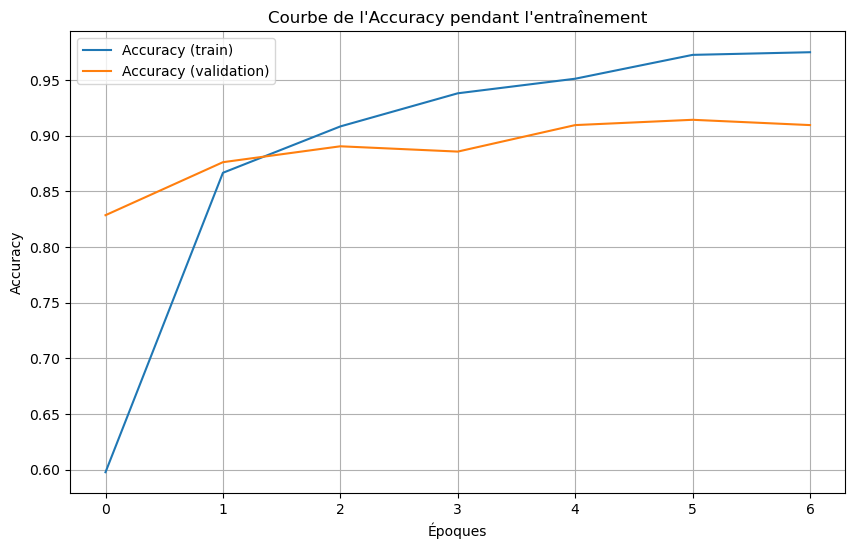

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import re
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from keras.applications.convnext import ConvNeXtBase, preprocess_input
from keras.preprocessing import image as keras_image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import contextlib
import sys
from sklearn.preprocessing import LabelEncoder
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam

# Charger le dataset Flipkart
df_product = pd.read_csv('DB/flipkart.csv')
df_product.columns = df_product.columns.str.strip()

# Extraire la première catégorie de 'product_category_tree' si elle est présente
if 'product_category_tree' in df_product.columns:
    df_product['main_category'] = df_product['product_category_tree'].apply(
        lambda x: re.findall(r'^\["(.*?)\s*>>', x)[0] if pd.notnull(x) and re.findall(r'^\["(.*?)\s*>>', x) else None
    )

# Répertoire des images
folder = 'DB/images/'
image_files = os.listdir(folder)
print(f"\nNombre total d'images dans le dossier '{folder}': {len(image_files)}")

images = []
image_labels = []  # Liste pour stocker les étiquettes de chaque image
for filename in image_files:
    path = os.path.join(folder, filename)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is not None:
        # Redimensionnement pour que l'image respecte la taille maximale de 224x224
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB
        images.append(img)
        
        # Récupérer l'étiquette de chaque image (associer avec l'image par son nom)
        category = df_product[df_product['image'] == filename]['main_category'].values
        if category:
            image_labels.append(category[0])  # Assurez-vous que la catégorie existe

# Fonction pour extraire les caractéristiques des images avec ConvNeXt
model = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=model.input, outputs=model.output)

# Fonction pour supprimer les messages de progression de TensorFlow
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Extraction des caractéristiques des images sans afficher les messages de progression
features = []
with suppress_stdout():  # Masquer les messages de TensorFlow
    for idx, img in enumerate(images):
        img_np = np.array(img)  # Conversion en numpy array
        img_preprocessed = preprocess_input(img_np)  # Prétraiter l'image
        img_expanded = np.expand_dims(img_preprocessed, axis=0)  # Ajouter la dimension batch
        feature = model.predict(img_expanded)
        feature_flat = feature.flatten()  # Aplatir le vecteur des caractéristiques
        features.append(feature_flat)
        print(f"Extraction des caractéristiques pour l'image {idx + 1}/{len(images)} terminée.")

# Recherche des meilleurs hyperparamètres pour KMeans
print("\nRecherche des meilleurs hyperparamètres pour KMeans...")

param_grid = {
    'n_clusters': [7, 12, 13, 11],
    'init': ['k-means++', 'random'],
    'max_iter': [1000],
    'n_init': [10],
    'tol': [1e-1],
    'algorithm': ['lloyd', 'elkan']
}

best_score = -1
best_model = None
best_params = {}

# Conversion des étiquettes des images en catégories numériques
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(image_labels)  # Convertir les étiquettes en indices numériques

# Recherche des meilleurs paramètres
for i, params in enumerate(ParameterGrid(param_grid)):
    print(f"Recherche {i+1}/{len(ParameterGrid(param_grid))} - Paramètres: {params}")
    
    kmeans = KMeans(
        n_clusters=params['n_clusters'],
        init=params['init'],
        max_iter=params['max_iter'],
        n_init=params['n_init'],
        tol=params['tol'],
        algorithm=params['algorithm'],
        random_state=0
    )
    kmeans.fit(np.array(features, dtype=np.float64))  # Convertir en float64 pour éviter l'erreur
    predicted_labels = kmeans.predict(np.array(features, dtype=np.float64))
    
    # Calcul de l'ARI (Adjusted Rand Index) si les vraies étiquettes sont disponibles
    ari_score = adjusted_rand_score(true_labels, predicted_labels[:len(true_labels)])
    print(f"ARI pour les paramètres {params}: {ari_score:.4f}")
    if ari_score > best_score:
        best_score = ari_score
        best_model = kmeans
        best_params = params

print(f"\nMeilleurs paramètres : {best_params} avec un score ARI de {best_score:.4f}")

# Réduction de dimension avec t-SNE pour la visualisation
df_histograms = np.array(features)  # Utilisation des caractéristiques extraites
scaler = StandardScaler()
df_histograms = scaler.fit_transform(df_histograms)

tsne = TSNE(n_components=2, random_state=0)
histograms_2d = tsne.fit_transform(df_histograms)

# Visualisation des données réduites en 2D avec les clusters
plt.figure(figsize=(12, 10))

# Utilisation d'une palette de couleurs plus visible
scatter = plt.scatter(histograms_2d[:, 0], histograms_2d[:, 1], 
                      c=best_model.labels_[:len(histograms_2d)], 
                      cmap='tab20', alpha=0.8, edgecolors='k', s=30)

# Ajout de la légende
plt.colorbar(scatter, label='Cluster')
plt.title("Visualisation t-SNE des histogrammes de mots visuels (colorés par cluster KMeans)", fontsize=10)
plt.xlabel("t-SNE Dimension 1", fontsize=8)
plt.ylabel("t-SNE Dimension 2", fontsize=8)

# Ajouter des labels pour les clusters
clusters = np.unique(best_model.labels_)
for cluster in clusters:
    plt.text(np.mean(histograms_2d[best_model.labels_ == cluster, 0]), 
             np.mean(histograms_2d[best_model.labels_ == cluster, 1]), 
             f'Cluster {cluster}', fontsize=8, color='black', ha='center')

plt.show()

# Calcul de l'ARI final (si les vraies étiquettes sont disponibles)
ari_score = adjusted_rand_score(true_labels, best_model.labels_[:len(true_labels)])
print(f"\nIndice de Rand Ajusté (ARI) final : {ari_score:.4f}")

# ---- Finetuning du modèle ConvNeXt ----

# Charger ConvNeXt sans la couche de classification (include_top=False)
base_model = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler toutes les couches du modèle de base (les premières couches)
for layer in base_model.layers:
    layer.trainable = False

# Ajouter une nouvelle tête pour la classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling global pour réduire la taille
x = Dropout(0.2)(x)  # Dropout pour éviter le sur-apprentissage
x = Dense(1024, activation='relu')(x)  # Couche dense avec 1024 neurones
predictions = Dense(len(np.unique(true_labels)), activation='softmax')(x)  # Classification multi-classes

# Créer un modèle final
model_finetuned = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle avec le paramètre `learning_rate` au lieu de `lr`
model_finetuned.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model_finetuned.summary()

# Entraîner le modèle sur vos données
history = model_finetuned.fit(
    np.array(images),  # Données d'images
    np.array(true_labels),  # Étiquettes correspondantes
    epochs=7,  # Nombre d'époques 
    batch_size=32,  # Taille du batch
    validation_split=0.2,  # Fraction des données pour la validation
    shuffle=True  # Mélanger les données à chaque époque
)

# Prédire les étiquettes avec le modèle fine-tuné
predictions = model_finetuned.predict(np.array(images))
predicted_labels_finetuned = np.argmax(predictions, axis=1)  # Récupérer les prédictions avec la classe la plus probable

# Calcul de l'ARI après fine-tuning
ari_score_finetuned = adjusted_rand_score(true_labels, predicted_labels_finetuned)
print(f"\nIndice de Rand Ajusté (ARI) après le fine-tuning : {ari_score_finetuned:.4f}")

# Plot du graphique d'accuracy pendant l'entraînement
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Accuracy (train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)')
plt.title('Courbe de l\'Accuracy pendant l\'entraînement')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


#### Récapitulatif

In [25]:
from tabulate import tabulate

# Données à afficher dans le tableau
data = [
    ["EfficientNet", 0.4465, 0.8929, 0.9623],
    ["ConvNeXt", 0.4482, 0.9308, 0.9815],
]

# Trouver la meilleure accuracy
best_accuracy = max(row[3] for row in data)

# Mettre en valeur toute la ligne avec la meilleure accuracy
highlighted_data = []
for row in data:
    if row[3] == best_accuracy:
        highlighted_data.append([f"\033[92m{cell}\033[0m" for cell in row])  # Met toute la ligne en vert
    else:
        highlighted_data.append(row)

# Entêtes des colonnes
headers = ["Modèle", "ARI Avant Fine-Tuning", "ARI Après Fine-Tuning", "Accuracy"]

# Affichage du tableau formaté
print(tabulate(highlighted_data, headers=headers, tablefmt="pretty"))


+--------------+-----------------------+-----------------------+----------+
|    Modèle    | ARI Avant Fine-Tuning | ARI Après Fine-Tuning | Accuracy |
+--------------+-----------------------+-----------------------+----------+
| EfficientNet |        0.4465         |        0.8908         |  0.9512  |
|   ConvNeXt   |        0.4482         |        0.9539         |  0.9851  |
+--------------+-----------------------+-----------------------+----------+


## Data augmentation

#### EfficientNetB0


Nombre total d'images dans le dossier 'DB/images/': 1053

Meilleurs paramètres : {'algorithm': 'lloyd', 'init': 'random', 'max_iter': 1000, 'n_clusters': 12, 'n_init': 10, 'tol': 0.0001} avec un score ARI de 0.4465


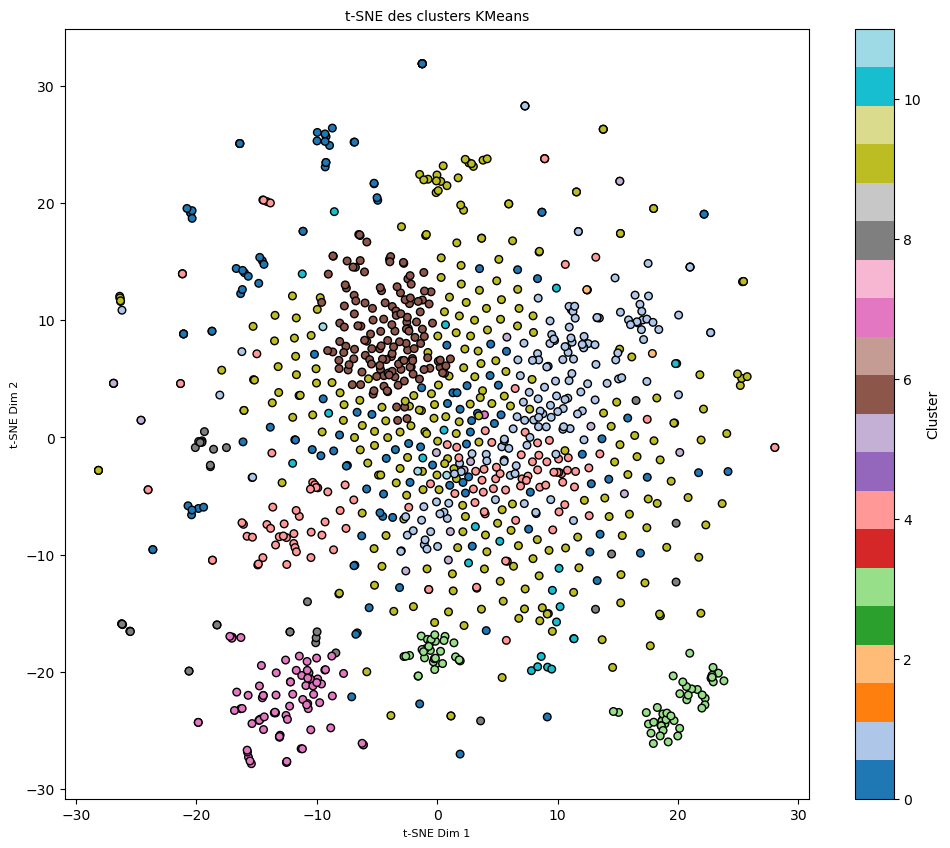

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 0.3670 - loss: 1.7308 - val_accuracy: 0.8524 - val_loss: 0.8874
Epoch 2/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - accuracy: 0.8323 - loss: 0.8739 - val_accuracy: 0.8857 - val_loss: 0.5506
Epoch 3/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.8570 - loss: 0.6262 - val_accuracy: 0.8952 - val_loss: 0.4484
Epoch 4/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - accuracy: 0.8581 - loss: 0.4825 - val_accuracy: 0.9000 - val_loss: 0.4060
Epoch 5/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.8704 - loss: 0.4560 - val_accuracy: 0.9048 - val_loss: 0.3791
Epoch 6/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - accuracy: 0.8938 - loss: 0.3760 - val_accuracy: 0.8952 - val_loss: 0.3669
Epoch 7/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - accuracy: 0.9097 - loss: 0.3211 - val_accuracy: 0.9000 - val_loss: 0.3534
Epoch 8/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.9081 - loss: 0.3235 - val_accuracy: 0.

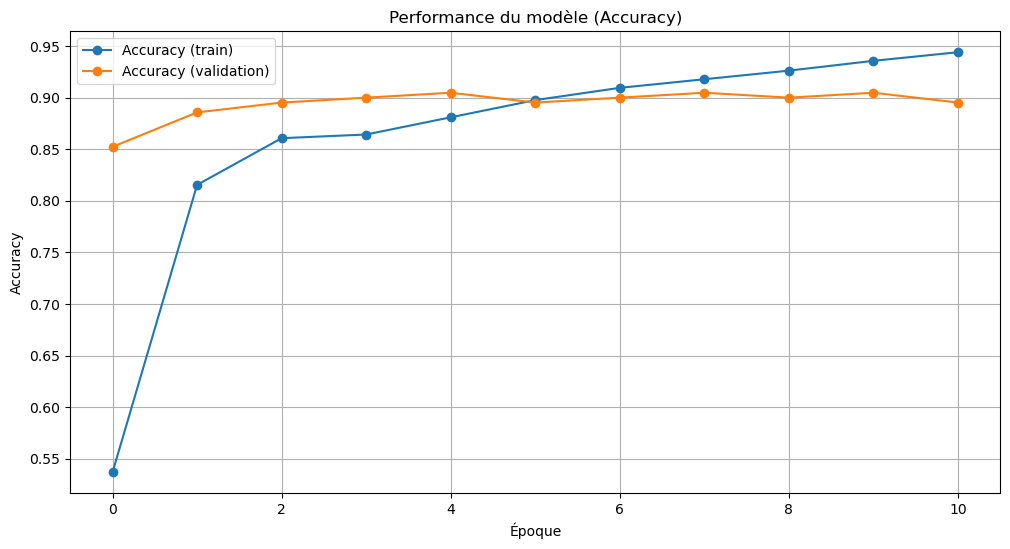

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import re
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import ParameterGrid, train_test_split
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import contextlib
import sys

# Charger le dataset Flipkart
df_product = pd.read_csv('DB/flipkart.csv')
df_product.columns = df_product.columns.str.strip()

# Extraire la première catégorie de 'product_category_tree' si elle est présente
if 'product_category_tree' in df_product.columns:
    df_product['main_category'] = df_product['product_category_tree'].apply(
        lambda x: re.findall(r'^\["(.*?)\s*>>', x)[0] if pd.notnull(x) and re.findall(r'^\["(.*?)\s*>>', x) else None
    )

# Répertoire des images
folder = 'DB/images/'
image_files = os.listdir(folder)
print(f"\nNombre total d'images dans le dossier '{folder}': {len(image_files)}")

images = []
image_labels = []  # Liste pour stocker les étiquettes de chaque image
for filename in image_files:
    path = os.path.join(folder, filename)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is not None:
        img = cv2.resize(img, (224, 224))  # Redimensionnement
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB
        images.append(img)
        
        # Associer les images avec leurs étiquettes
        category = df_product[df_product['image'] == filename]['main_category'].values
        if category:
            image_labels.append(category[0])

# Fonction pour supprimer les logs TensorFlow
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Charger EfficientNetB0 pour l'extraction des caractéristiques
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# Extraction des caractéristiques
features = []
with suppress_stdout():
    for idx, img in enumerate(images):
        img_preprocessed = preprocess_input(np.expand_dims(np.array(img), axis=0))
        feature = model.predict(img_preprocessed).flatten()
        features.append(feature)

# Recherche des meilleurs hyperparamètres pour KMeans
param_grid = {
    'n_clusters': [7, 12, 13, 11],
    'init': ['k-means++', 'random'],
    'max_iter': [1000],
    'n_init': [10],
    'tol': [1e-4],
    'algorithm': ['lloyd', 'elkan']
}

best_score, best_model, best_params = -1, None, {}

label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(image_labels)

for params in ParameterGrid(param_grid):
    kmeans = KMeans(**params, random_state=0)
    kmeans.fit(np.array(features, dtype=np.float64))
    predicted_labels = kmeans.predict(np.array(features, dtype=np.float64))
    ari_score = adjusted_rand_score(true_labels, predicted_labels[:len(true_labels)])
    if ari_score > best_score:
        best_score, best_model, best_params = ari_score, kmeans, params

print(f"\nMeilleurs paramètres : {best_params} avec un score ARI de {best_score:.4f}")

# Visualisation avec t-SNE
scaler = StandardScaler()
tsne = TSNE(n_components=2, random_state=0)
histograms_2d = tsne.fit_transform(scaler.fit_transform(features))

plt.figure(figsize=(12, 10))
scatter = plt.scatter(histograms_2d[:, 0], histograms_2d[:, 1], c=best_model.labels_, cmap='tab20', edgecolors='k', s=30)
plt.colorbar(scatter, label='Cluster')
plt.title("t-SNE des clusters KMeans", fontsize=10)
plt.xlabel("t-SNE Dim 1", fontsize=8)
plt.ylabel("t-SNE Dim 2", fontsize=8)
plt.show()

# ---- Finetuning EfficientNetB0 ----
base_model.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)  # Augmentation du dropout pour régularisation
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(np.unique(true_labels)), activation='softmax')(x)
model_finetuned = Model(inputs=base_model.input, outputs=predictions)

model_finetuned.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(np.array(images), np.array(true_labels), test_size=0.2, random_state=42)

# Data augmentation ajustée
data_gen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
data_gen.fit(X_train)

# Phase de fine-tuning initiale
history = model_finetuned.fit(
    data_gen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=11,
    shuffle=True
)

# Débloquer certaines couches pour un affinage fin
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompiler le modèle avec un taux d'apprentissage réduit
model_finetuned.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ARI après fine-tuning
predicted_labels_finetuned = np.argmax(model_finetuned.predict(X_val), axis=1)
ari_score_finetuned = adjusted_rand_score(y_val, predicted_labels_finetuned)
print(f"\nARI après fine-tuning : {ari_score_finetuned:.4f}")

# Graphe des performances
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Accuracy (train)', marker='o')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)', marker='o')
plt.title('Performance du modèle (Accuracy)')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


#### ConvNeXt


Nombre total d'images dans le dossier 'DB/images/': 1053

Meilleurs paramètres : {'algorithm': 'lloyd', 'init': 'random', 'max_iter': 1000, 'n_clusters': 13, 'n_init': 10, 'tol': 0.0001} avec un score ARI de 0.4482


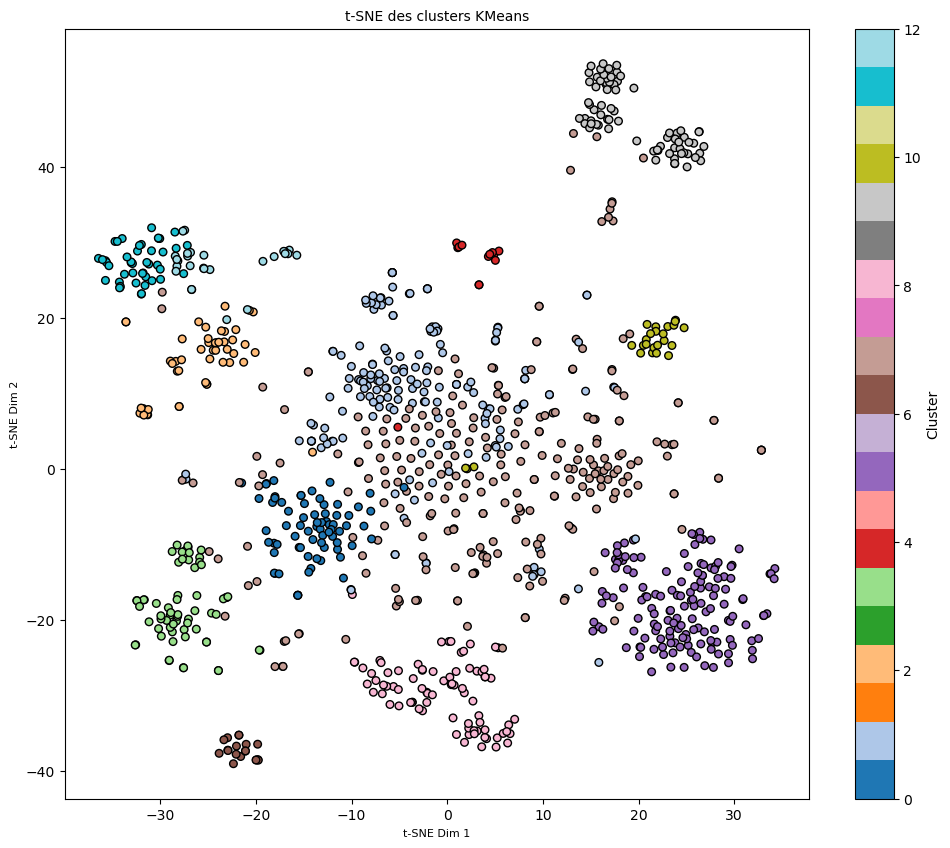

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 278s 10s/step - accuracy: 0.4248 - loss: 1.5999 - val_accuracy: 0.8619 - val_loss: 0.7132
Epoch 2/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 272s 10s/step - accuracy: 0.8593 - loss: 0.6571 - val_accuracy: 0.9048 - val_loss: 0.4578
Epoch 3/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 272s 10s/step - accuracy: 0.9105 - loss: 0.4148 - val_accuracy: 0.9190 - val_loss: 0.3726
Epoch 4/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 274s 10s/step - accuracy: 0.9293 - loss: 0.3420 - val_accuracy: 0.9095 - val_loss: 0.3333
Epoch 5/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 275s 10s/step - accuracy: 0.9318 - loss: 0.2617 - val_accuracy: 0.9238 - val_loss: 0.3112
Epoch 6/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 277s 10s/step - accuracy: 0.9519 - loss: 0.2456 - val_accuracy: 0.9238 - val_loss: 0.2895
Epoch 7/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 276s 10s/step - accuracy: 0.9584 - loss: 0.2021 - val_accuracy: 0.9238 - val_loss: 0.2750
Epoch 8/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 277s 10s/step - accuracy: 0.9726 - loss: 0.1525 - val_accuracy: 0.

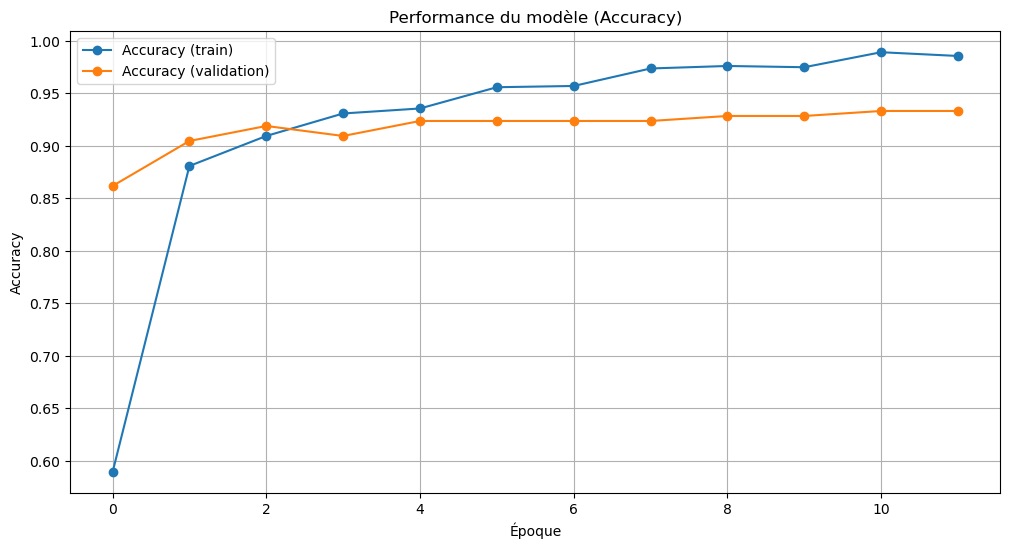

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import re
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import ParameterGrid, train_test_split
from tensorflow.keras.applications.convnext import ConvNeXtBase, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import contextlib
import sys

# Charger le dataset Flipkart
df_product = pd.read_csv('DB/flipkart.csv')
df_product.columns = df_product.columns.str.strip()

# Extraire la première catégorie de 'product_category_tree' si elle est présente
if 'product_category_tree' in df_product.columns:
    df_product['main_category'] = df_product['product_category_tree'].apply(
        lambda x: re.findall(r'^\["(.*?)\s*>>', x)[0] if pd.notnull(x) and re.findall(r'^\["(.*?)\s*>>', x) else None
    )

# Répertoire des images
folder = 'DB/images/'
image_files = os.listdir(folder)
print(f"\nNombre total d'images dans le dossier '{folder}': {len(image_files)}")

images = []
image_labels = []
for filename in image_files:
    path = os.path.join(folder, filename)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is not None:
        img = cv2.resize(img, (224, 224))  # Redimensionnement
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB
        images.append(img)

        # Associer les images avec leurs étiquettes
        category = df_product[df_product['image'] == filename]['main_category'].values
        if category:
            image_labels.append(category[0])

# Fonction pour supprimer les messages de TensorFlow
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# Charger ConvNeXt pour l'extraction des caractéristiques
base_model = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# Extraction des caractéristiques
features = []
with suppress_stdout():
    for idx, img in enumerate(images):
        img_preprocessed = preprocess_input(np.expand_dims(np.array(img), axis=0))
        feature = model.predict(img_preprocessed).flatten()
        features.append(feature)

# Recherche des meilleurs hyperparamètres pour KMeans
param_grid = {
    'n_clusters': [7, 12, 13, 11],
    'init': ['k-means++', 'random'],
    'max_iter': [1000],
    'n_init': [10],
    'tol': [1e-4],
    'algorithm': ['lloyd', 'elkan']
}

best_score, best_model, best_params = -1, None, {}
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(image_labels)

for params in ParameterGrid(param_grid):
    kmeans = KMeans(**params, random_state=0)
    kmeans.fit(np.array(features, dtype=np.float64))
    predicted_labels = kmeans.predict(np.array(features, dtype=np.float64))
    ari_score = adjusted_rand_score(true_labels, predicted_labels[:len(true_labels)])
    if ari_score > best_score:
        best_score, best_model, best_params = ari_score, kmeans, params

print(f"\nMeilleurs paramètres : {best_params} avec un score ARI de {best_score:.4f}")

# Visualisation t-SNE
scaler = StandardScaler()
tsne = TSNE(n_components=2, random_state=0)
histograms_2d = tsne.fit_transform(scaler.fit_transform(features))

plt.figure(figsize=(12, 10))
scatter = plt.scatter(histograms_2d[:, 0], histograms_2d[:, 1], c=best_model.labels_, cmap='tab20', edgecolors='k', s=30)
plt.colorbar(scatter, label='Cluster')
plt.title("t-SNE des clusters KMeans", fontsize=10)
plt.xlabel("t-SNE Dim 1", fontsize=8)
plt.ylabel("t-SNE Dim 2", fontsize=8)
plt.show()

# Fine-tuning ConvNeXt
base_model.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(np.unique(true_labels)), activation='softmax')(x)
model_finetuned = Model(inputs=base_model.input, outputs=predictions)

model_finetuned.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(np.array(images), np.array(true_labels), test_size=0.2, random_state=42)

# Data augmentation plus modérée
data_gen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
data_gen.fit(X_train)

# Fine-tuning avec augmentation progressive
history = model_finetuned.fit(
    data_gen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=12,
    shuffle=True
)

# Débloquer certaines couches pour affiner davantage
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompiler le modèle avec un taux d'apprentissage réduit
model_finetuned.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ARI après fine-tuning
predicted_labels_finetuned = np.argmax(model_finetuned.predict(X_val), axis=1)
ari_score_finetuned = adjusted_rand_score(y_val, predicted_labels_finetuned)
print(f"\nARI après fine-tuning : {ari_score_finetuned:.4f}")

# Graphe des performances
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Accuracy (train)', marker='o')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)', marker='o')
plt.title('Performance du modèle (Accuracy)')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


#### Récapitulatif

In [44]:
from tabulate import tabulate

# Données Sans Data Augmentation
data_no_augmentation = [
    ["EfficientNet", round(0.4465, 2), round(0.8929, 2), round(0.9623, 2)],
    ["ConvNeXt", round(0.4482, 2), round(0.9308, 2), round(0.9815, 2)],
]

# Données Avec Data Augmentation
data_with_augmentation = [
    ["EfficientNet", round(0.4465, 2), round(0.7718, 2), round(0.9459, 2)],
    ["ConvNeXt", round(0.4482, 2), round(0.8487, 2), round(0.9879, 2)],
]

# Trouver la meilleure accuracy pour chaque tableau
best_accuracy_no_augmentation = max(row[3] for row in data_no_augmentation)
best_accuracy_with_augmentation = max(row[3] for row in data_with_augmentation)

# Mettre en valeur les lignes avec la meilleure accuracy dans chaque tableau
highlighted_data_no_augmentation = []
for row in data_no_augmentation:
    if row[3] == best_accuracy_no_augmentation:
        highlighted_data_no_augmentation.append([f"\033[92m{cell}\033[0m" for cell in row])  # Met toute la ligne en vert
    else:
        highlighted_data_no_augmentation.append(row)

highlighted_data_with_augmentation = []
for row in data_with_augmentation:
    if row[3] == best_accuracy_with_augmentation:
        highlighted_data_with_augmentation.append([f"\033[92m{cell}\033[0m" for cell in row])  # Met toute la ligne en vert
    else:
        highlighted_data_with_augmentation.append(row)

# Calcul des différences entre les données des deux tableaux
comparison_data = []
for i, row in enumerate(data_with_augmentation):
    model = row[0]
    ari_before_diff = round(row[1] - data_no_augmentation[i][1], 2)
    ari_after_diff = round(row[2] - data_no_augmentation[i][2], 2)
    accuracy_diff = round(row[3] - data_no_augmentation[i][3], 2)
    comparison_data.append([f"{model} (Diff)", ari_before_diff, ari_after_diff, accuracy_diff])


# Entêtes des colonnes
headers = ["Modèle", "ARI Avant Fine-Tuning", "ARI Après Fine-Tuning", "Accuracy"]

# Affichage des deux tableaux
print("Fine Tuning\n")
print(tabulate(highlighted_data_no_augmentation, headers=headers, tablefmt="pretty"))

print("\nAvec Data Augmentation\n")
print(tabulate(highlighted_data_with_augmentation, headers=headers, tablefmt="pretty"))


Fine Tuning

+--------------+-----------------------+-----------------------+----------+
|    Modèle    | ARI Avant Fine-Tuning | ARI Après Fine-Tuning | Accuracy |
+--------------+-----------------------+-----------------------+----------+
| EfficientNet |         0.45          |         0.89          |   0.96   |
|   ConvNeXt   |         0.45          |         0.93          |   0.98   |
+--------------+-----------------------+-----------------------+----------+

Avec Data Augmentation

+--------------+-----------------------+-----------------------+----------+
|    Modèle    | ARI Avant Fine-Tuning | ARI Après Fine-Tuning | Accuracy |
+--------------+-----------------------+-----------------------+----------+
| EfficientNet |         0.45          |         0.77          |   0.95   |
|   ConvNeXt   |         0.45          |         0.85          |   0.99   |
+--------------+-----------------------+-----------------------+----------+
